In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import random


TRAIN_DIR = r'C:\Users\MDAHSAMULHAQUE\Desktop\MIDTERM\animals'
CATEGORIES = os.listdir(TRAIN_DIR)

IMG_SIZE = 32
TRAIN_DATA = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path), desc=f"Loading {c}"):
        try:
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
            TRAIN_DATA.append([img_arr.flatten() / 255.0, class_num])
        except Exception as e:
            print(f"Error loading image {img}: {e}")  # Helpful for debugging

random.shuffle(TRAIN_DATA)
TRAIN_DATA = TRAIN_DATA[:100]  # limit to 100 images
print("Total images used:", len(TRAIN_DATA))


Loading dogs:   0%|                                                                           | 0/1000 [00:00<?, ?it/s]

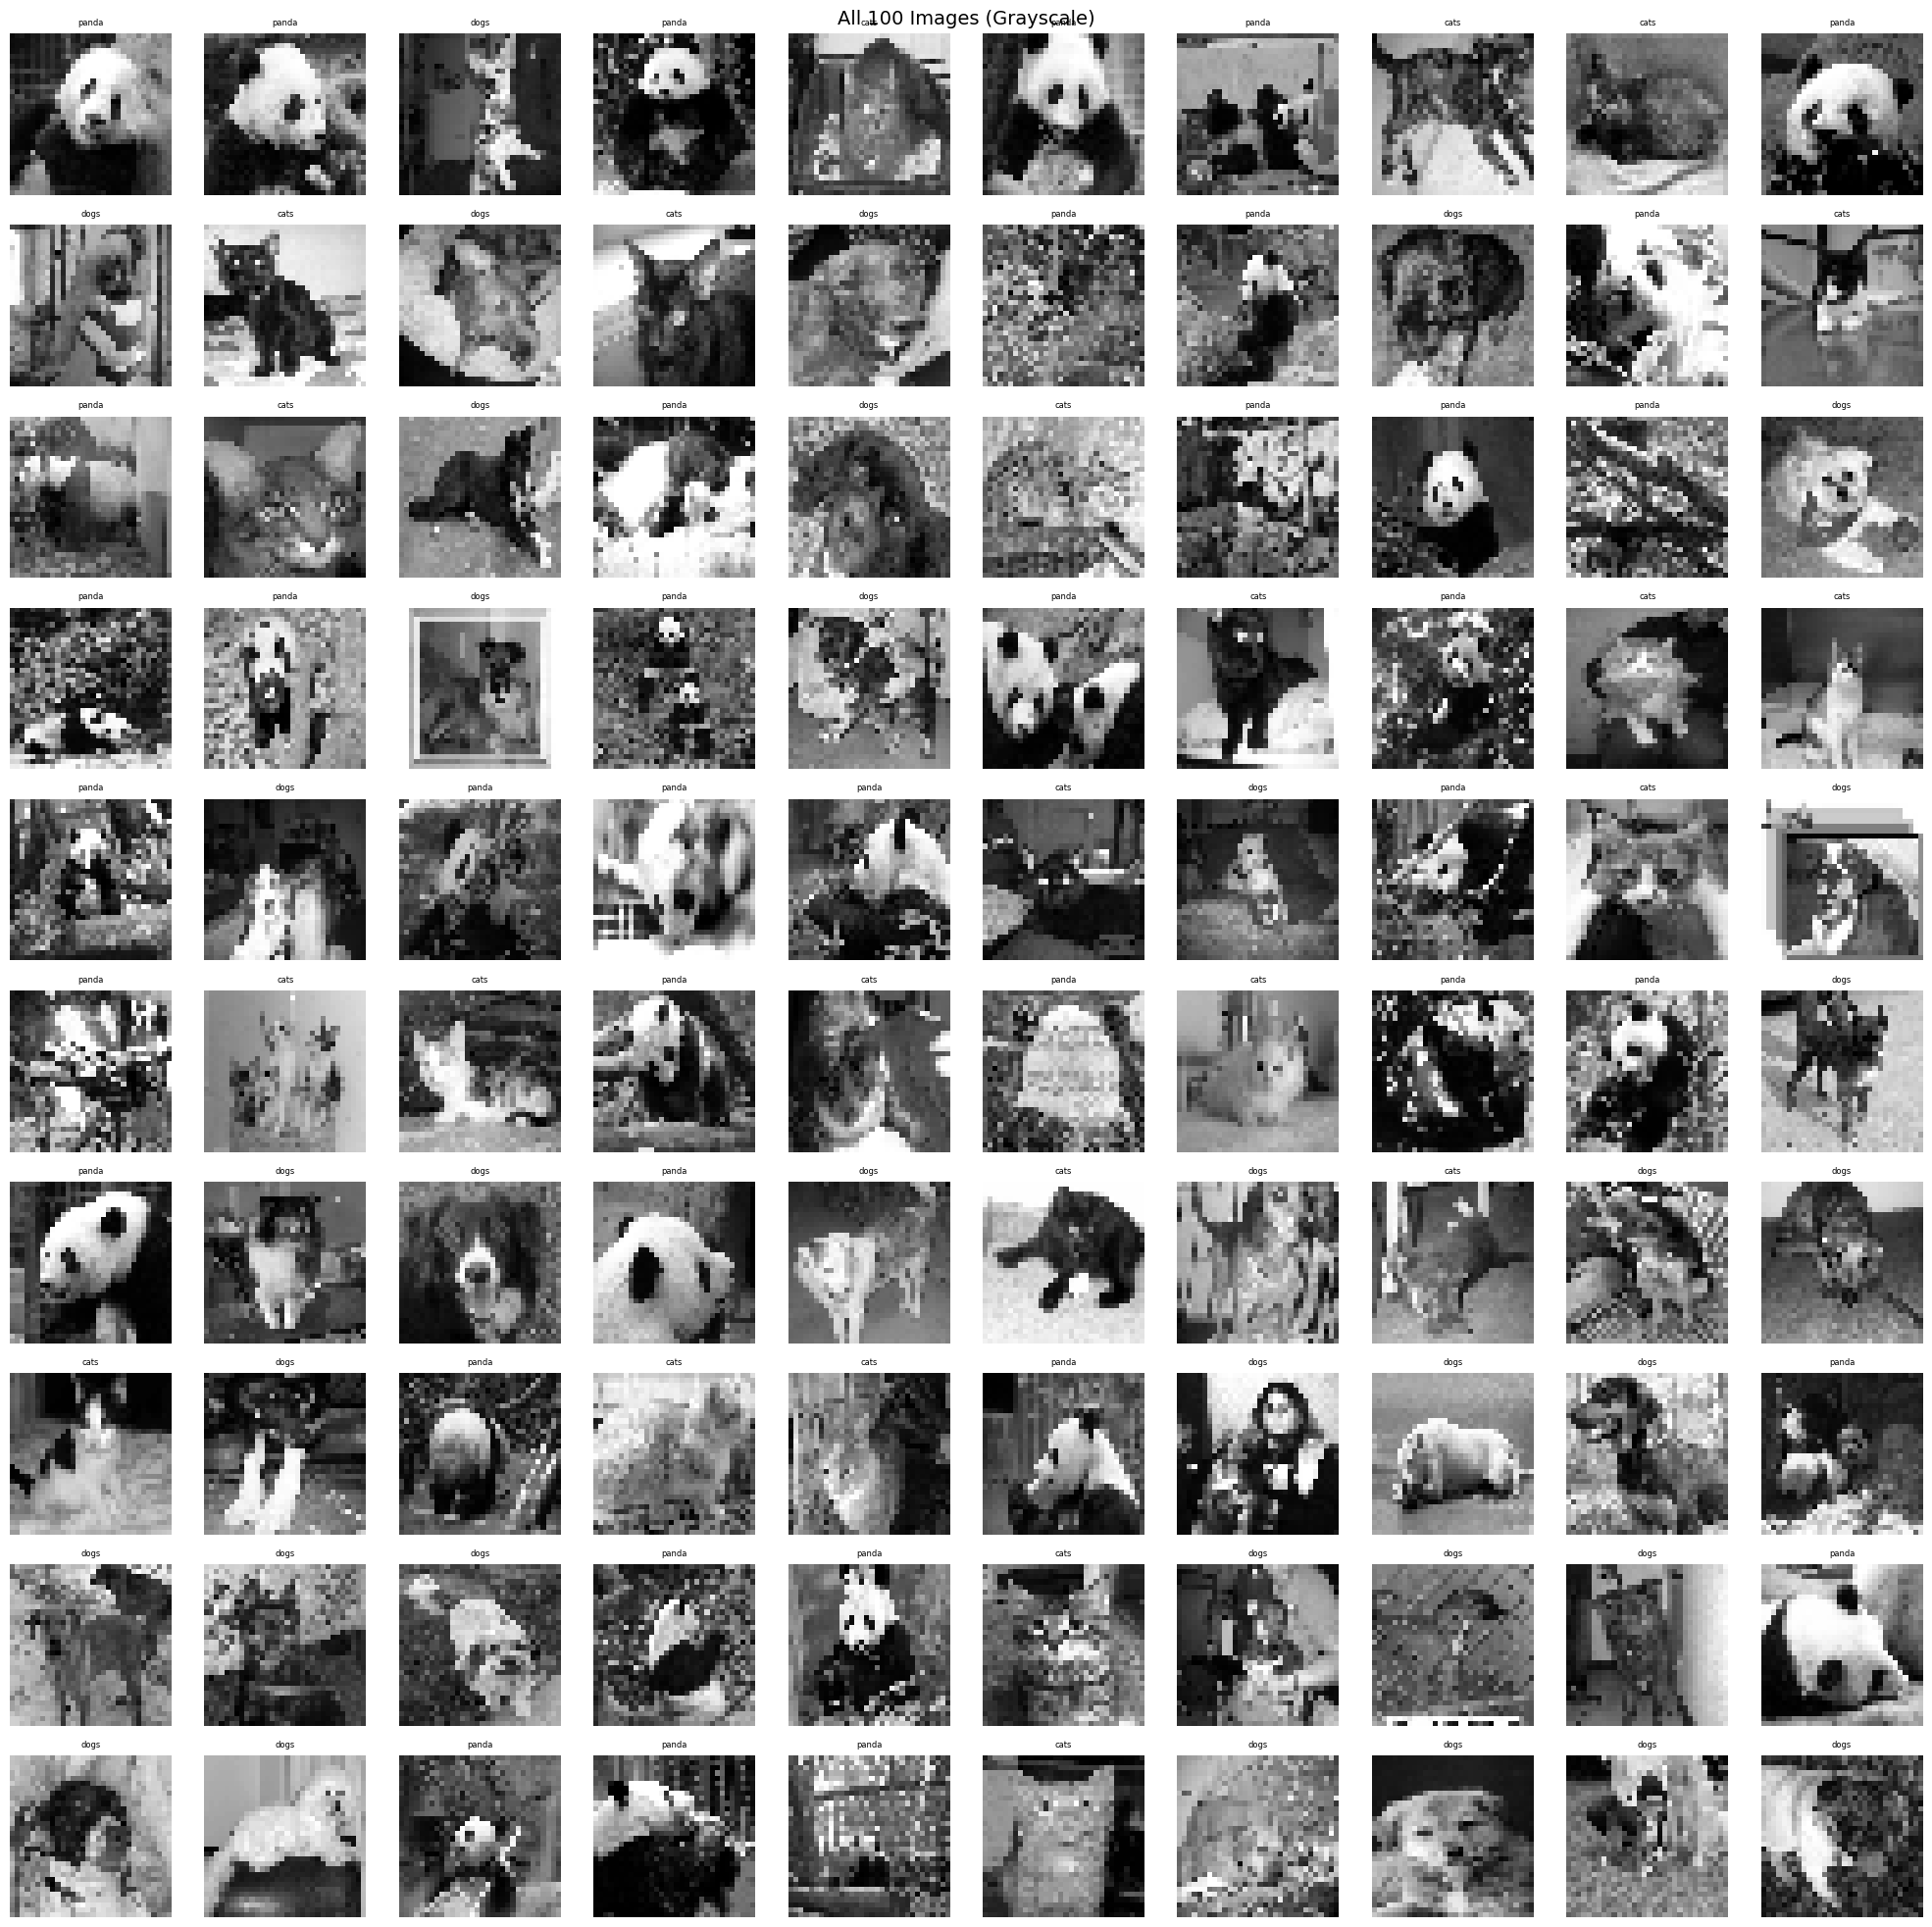

In [22]:
# Display all 100 grayscale images used in TRAIN_DATA
 
plt.figure(figsize=(20, 20))
 
for i in range(100):

    image_flat, label = TRAIN_DATA[i]

    image = (image_flat.reshape(32, 32) * 255).astype('uint8')
 
    plt.subplot(10, 10, i + 1)

    plt.imshow(image, cmap='gray')

    plt.title(CATEGORIES[label], fontsize=6)

    plt.axis('off')
 
plt.suptitle("All 100 Images (Grayscale)", fontsize=14)

plt.tight_layout()

plt.show()

 

In [19]:
X = [x[0] for x in TRAIN_DATA]
y = [x[1] for x in TRAIN_DATA]

Folds = []
for i in range(5):
    fold = [(X[j], y[j]) for j in range(i, len(X), 5)]
    Folds.append(fold)

for i, fold in enumerate(Folds):
    print(f"Fold {i+1}: {len(fold)} samples")

Fold 1: 20 samples
Fold 2: 20 samples
Fold 3: 20 samples
Fold 4: 20 samples
Fold 5: 20 samples


In [4]:
def l1_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def l2_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [5]:
def knn_predict(distances, k):
    distances.sort()
    labels = [label for _, label in distances[:k]]
    return Counter(labels).most_common(1)[0][0]

In [12]:
def classification_report(y_true, y_pred, num_classes):
    print("\nClassification Report:")
    for cls in range(num_classes):
        TP = sum((p == cls and t == cls) for p, t in zip(y_pred, y_true))
        FP = sum((p == cls and t != cls) for p, t in zip(y_pred, y_true))
        FN = sum((p != cls and t == cls) for p, t in zip(y_pred, y_true))
        precision = TP / (TP + FP + 1e-10)
        recall = TP / (TP + FN + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)
        print(f"Class {cls} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

def confusion_matrix(y_true, y_pred, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        matrix[t][p] += 1
    print("\nConfusion Matrix:")
    print(matrix)

In [13]:
def evaluate_knn(distance_func, label=""):
    k_best = 3
    y_true_all = []
    y_pred_all = []

    for fold_index in range(5):
        validation_set = Folds[fold_index]
        training_set = [item for i, fold in enumerate(Folds) if i != fold_index for item in fold]

        for val_img, val_label in validation_set:
            distances = [(distance_func(val_img, train_img), train_label)
                         for train_img, train_label in training_set]
            pred = knn_predict(distances, k_best)
            y_true_all.append(val_label)
            y_pred_all.append(pred)

    print(f"\nResults for {label}:")
    classification_report(y_true_all, y_pred_all, num_classes=len(CATEGORIES))
    confusion_matrix(y_true_all, y_pred_all, num_classes=len(CATEGORIES))

In [14]:
print("Evaluating with L2 (Euclidean):")
evaluate_knn(l2_distance, "L2 (Euclidean)")

print("\nEvaluating with L1 (Manhattan):")
evaluate_knn(l1_distance, "L1 (Manhattan)")

Evaluating with L2 (Euclidean):

Results for L2 (Euclidean):

Classification Report:
Class 0 - Precision: 0.40, Recall: 0.51, F1: 0.45
Class 1 - Precision: 0.25, Recall: 0.39, F1: 0.30
Class 2 - Precision: 1.00, Recall: 0.02, F1: 0.03

Confusion Matrix:
[[37 35  0]
 [41 26  0]
 [15 45  1]]

Evaluating with L1 (Manhattan):

Results for L1 (Manhattan):

Classification Report:
Class 0 - Precision: 0.39, Recall: 0.46, F1: 0.42
Class 1 - Precision: 0.30, Recall: 0.46, F1: 0.36
Class 2 - Precision: 0.73, Recall: 0.13, F1: 0.22

Confusion Matrix:
[[33 36  3]
 [36 31  0]
 [15 38  8]]


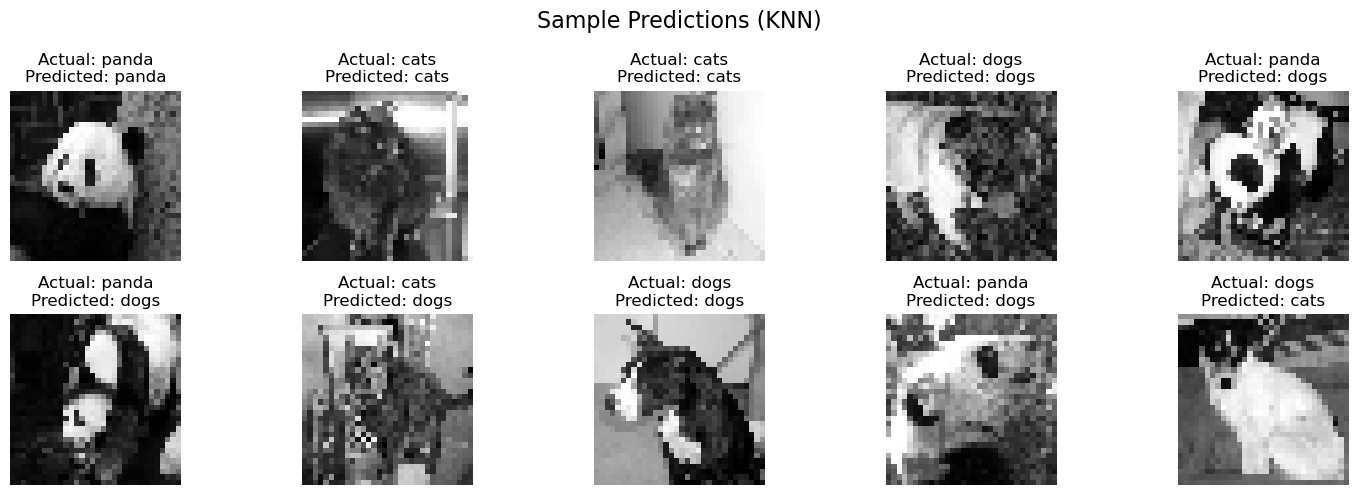

In [15]:
def show_predictions(distance_func, k=3, num_samples=10):
    # Merge all data from folds
    full_data = [item for fold in Folds for item in fold]
    random.shuffle(full_data)
 
    samples = full_data[:num_samples]
    training_data = full_data[num_samples:]  # exclude test samples from training
 
    plt.figure(figsize=(15, 5))
    for i, (img_vec, true_label) in enumerate(samples):
        # KNN prediction
        distances = [(distance_func(img_vec, train_img), train_label)
                     for train_img, train_label in training_data]
        pred_label = knn_predict(distances, k)
 
        # Convert flat image back to 32×32 for display
        img = (img_vec.reshape(32, 32) * 255).astype('uint8')
 
        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {CATEGORIES[true_label]}\nPredicted: {CATEGORIES[pred_label]}")
        plt.axis('off')
 
    plt.suptitle("Sample Predictions (KNN)", fontsize=16)
    plt.tight_layout()
    plt.show()
 
# Example: Show with L2 distance
show_predictions(l2_distance, k=3)

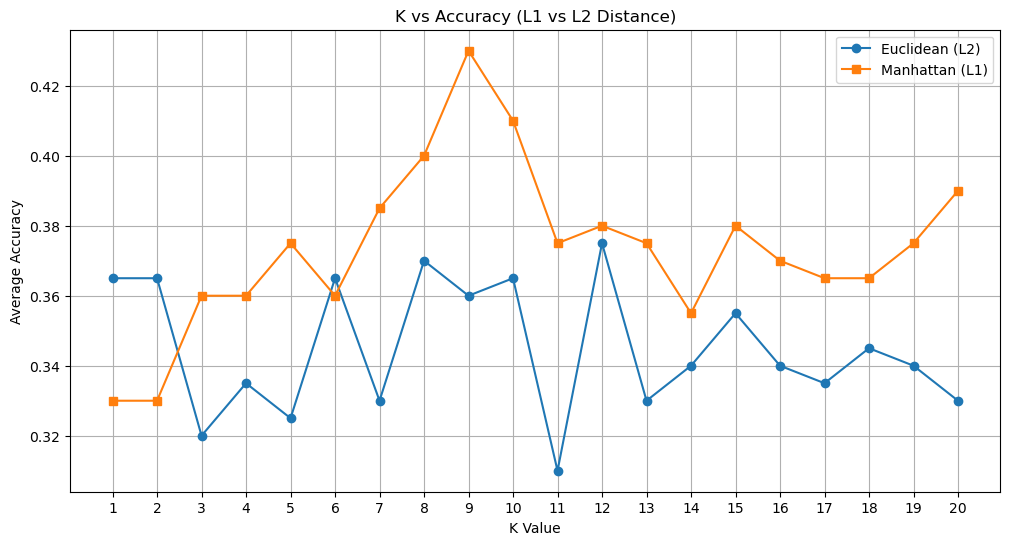

In [16]:
# Graphical comparison of accuracy vs K for both L1 and L2 distances
 
def evaluate_and_plot_all():
    def evaluate_for_distance(distance_func):
        avg_results = []
        for k in range(1, 21):
            fold_accuracies = []
            for fold_index in range(5):
                validation_set = Folds[fold_index]
                training_set = [item for i, fold in enumerate(Folds) if i != fold_index for item in fold]
 
                predictions = []
                for val_img, val_label in validation_set:
                    distances = [(distance_func(val_img, train_img), train_label)
                                 for train_img, train_label in training_set]
                    pred = knn_predict(distances, k)
                    predictions.append(1 if pred == val_label else 0)
 
                acc = sum(predictions) / len(predictions)
                fold_accuracies.append(acc)
 
            avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
            avg_results.append(avg_accuracy)
        return avg_results
 
    # Evaluate both distance methods
    l2_results = evaluate_for_distance(l2_distance)
    l1_results = evaluate_for_distance(l1_distance)
 
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 21), l2_results, marker='o', label='Euclidean (L2)')
    plt.plot(range(1, 21), l1_results, marker='s', label='Manhattan (L1)')
    plt.xlabel('K Value')
    plt.ylabel('Average Accuracy')
    plt.title('K vs Accuracy (L1 vs L2 Distance)')
    plt.xticks(range(1, 21))
    plt.legend()
    plt.grid(True)
    plt.show()
 
# Call the function
evaluate_and_plot_all()